# **Gold Price Forecasting with ARIMA**

## **Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **Loading Dataset**

In [ ]:
def wrangle(path):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    desired_frequency = 'D'
    df = df.asfreq(desired_frequency)

    df = df['High']
    return df

This is a function to:
1. read in the csv data file,
2. set the date column to the right format,
3. make the date the index,
4. the date index needs a 'frequency' e.g. daily, so that there are no missing dates
5. fill missing values (non-trading days) using forward fill.

In [ ]:
file_path = "/content/drive/MyDrive/Data Science Learning/7. ML Projects /2. Gold Price Analysis/Gold Price Forecasting (Medium)/Gold Historical Data Max.csv"

Gold=wrangle(file_path)
Gold

,High
Date,
2014-09-25,1225.3
2014-09-26,1232.7
2014-09-27,NaN
2014-09-28,NaN
2014-09-29,1223.9
...,...
2024-09-20,2651.0
2024-09-21,NaN
2024-09-22,NaN


## **Dissecting the time series into its trend, seasonality, and residual components**

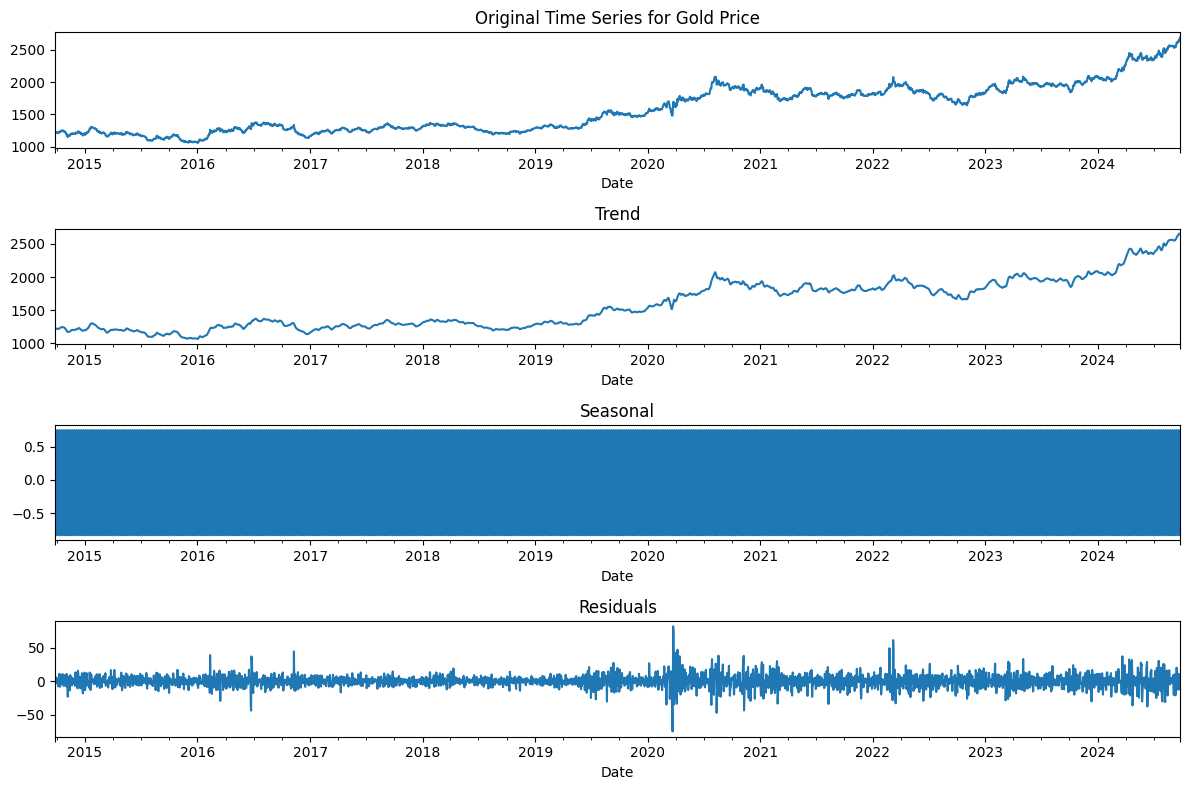

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Drop missing values initially, set frequency, and then forward-fill new missing values
Gold_clean = Gold.dropna().asfreq('D').ffill()

# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(Gold_clean, model='additive')

# Create subplots for decomposition results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

Gold_clean.plot(ax=ax1, title='Original Time Series for Gold Price')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
decomposition.resid.plot(ax=ax4, title='Residuals')

plt.tight_layout()
plt.show()

### **Observation:**
***

> ## 1. The seasonality component exhibits a consistent pattern recurring across the entire time frame

> ## 2. Residuals appear to be nearly random and normal

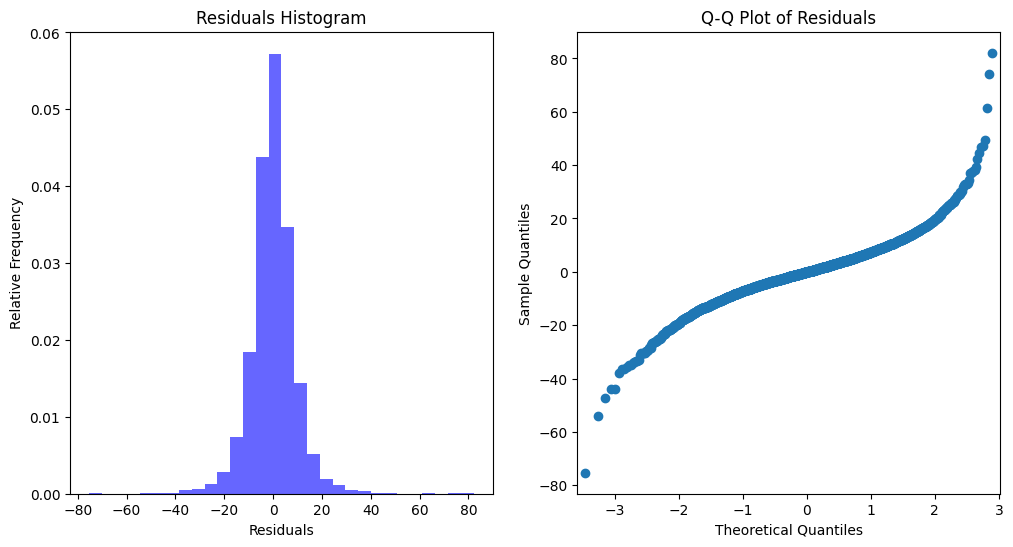

In [ ]:
#Histogram for the Residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(decomposition.resid, bins=30, density=True, alpha=0.6, color='b')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Relative Frequency')

#Q-Q plot of the residuals
plt.subplot(1, 2, 2)
sm.qqplot(decomposition.resid, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Residuals')

plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


Text(0, 0.5, 'Autocorrelation')

<Figure size 1000x500 with 0 Axes>

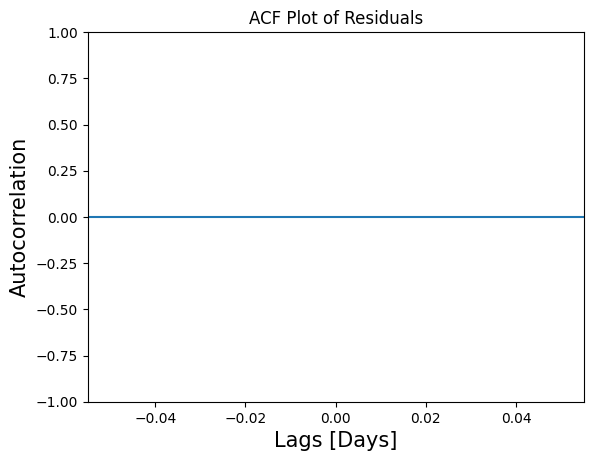

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 5))
plot_acf(decomposition.resid, lags=50)
plt.title('ACF Plot of Residuals')
plt.xlabel("Lags [Days]", fontsize=15)
plt.ylabel("Autocorrelation", fontsize=15)

### **Observation:**
***

> ## An examination of the autocorrelation function (ACF) plot for the residuals also indicates an absence of correlation between earlier and subsequent values. This suggests that there is essentially ‘no signal’ left in the residuals i.e., the residuals represent noise. I will thus exclude them from the final predictions.

## **Training the ARIMA Model & Forecasting**

In [ ]:
trend=decomposition.trend.dropna()
trend

,trend
Date,
2014-09-28,1226.857143
2014-09-29,1226.671429
2014-09-30,1224.242857
2014-10-01,1221.814286
2014-10-02,1219.385714
...,...
2024-09-17,2622.714286
2024-09-18,2627.914286
2024-09-19,2633.114286


> ## We see that the values span from **`28 Sep 2014`** to **`21 Sep 2024`**

<Figure size 1000x500 with 0 Axes>

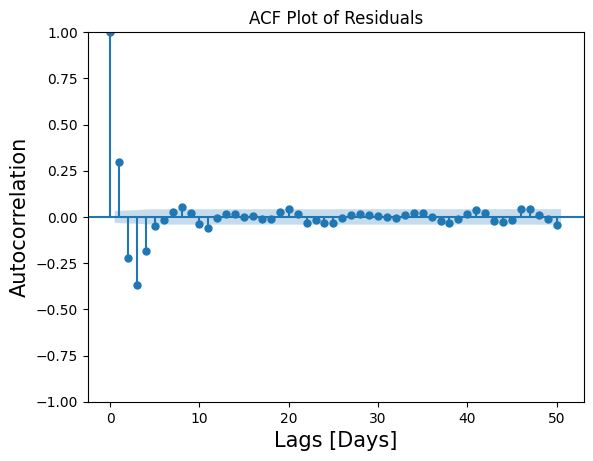

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Use non-missing residuals
residuals = decomposition.resid.dropna()

# Plot ACF
plt.figure(figsize=(10, 5))
plot_acf(residuals, lags=50)  # Adjust lags if necessary
plt.title('ACF Plot of Residuals')
plt.xlabel("Lags [Days]", fontsize=15)
plt.ylabel("Autocorrelation", fontsize=15)
plt.show()

## **Observation:**

### From the PACF plot, we see that the trend value at an instance in time is strongly correlated with its value on the previous day. In fact, the correlation is statistically significant with values up to 5 days before. After 5 days, the correlation dips into the blue band suggesting that the correlations are no longer statistically significant. We will thus set p = 5.

## **Splitting the trend data into the training and test sets**
***

### In expanding window validation,
### 1. We will first train the model using data from 28 Sep 2014 to 23 Sep 2022 (~80% of the dataset) and use the fitted model to predict the price of gold on 24 Sep 2022.

### 2. Moving on to the next prediction for 25 Sep 2022, I will use the historical price of gold from 28 Sep 2014 to 24 Sep 2022.

### 3. Hence, the training set now has an extra data point, incorporating the most recent price of gold prior to the one being forecasted.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Ensure y_train and y_test are properly split
y_train = trend[:int(0.80 * len(trend))]
y_test = trend[int(0.80 * len(trend)):]

# Initialize an empty series with proper index
y_prediction = pd.Series(index=y_test.index, dtype=float)

# History starts with training data
history = y_train.copy()

# Walk-forward validation loop
for i in range(len(y_test)):
    # Train the ARIMA model on the current history
    ARIMA_Model = ARIMA(history, order=(4,1,1)).fit()

    # Forecast the next step (single timestamp)
    next_prediction = ARIMA_Model.forecast(steps=1)

    # Assign the forecast to the correct index in y_prediction
    y_prediction.iloc[i] = next_prediction

    # Update history by appending the actual value from y_test
    history = pd.concat([history, pd.Series([y_test.iloc[i]], index=[y_test.index[i]])])

# Now the indices of y_prediction should match y_test


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

In [ ]:
from sklearn.metrics import mean_absolute_error

# Add the predictions to the DataFrame for comparison
df_results = pd.DataFrame({
    'Actual Gold Price': y_test,
    'Predicted Gold Price': y_prediction
})

# Calculate the mean price for the 'Mean Gold Price' column (using the training set mean)
df_results['Mean Gold Price'] = y_train.mean()

In [ ]:
df_results

,Actual Gold Price,Predicted Gold Price,Mean Gold Price
Date,,,
2022-09-23,1684.485714,1688.898421,1456.802018
2022-09-24,1678.957143,1680.569710,1456.802018
2022-09-25,1675.342857,1674.372283,1456.802018
2022-09-26,1672.428571,1672.266940,1456.802018
2022-09-27,1672.342857,1669.974124,1456.802018
...,...,...,...
2024-09-17,2622.714286,2620.257587,1456.802018
2024-09-18,2627.914286,2626.651917,1456.802018
2024-09-19,2633.114286,2631.260399,1456.802018


In [ ]:
# Calculate MAE for predictions and mean model
mae_pred = mean_absolute_error(df_results["Actual Gold Price"], df_results["Predicted Gold Price"])
mae_av = mean_absolute_error(df_results["Actual Gold Price"], df_results["Mean Gold Price"])

print("mae_pred: ", mae_pred)
print("mae_av:", mae_av)

mae_pred:  1.8685917019118659
mae_av: 607.1107807058559


## **Plotting the results**


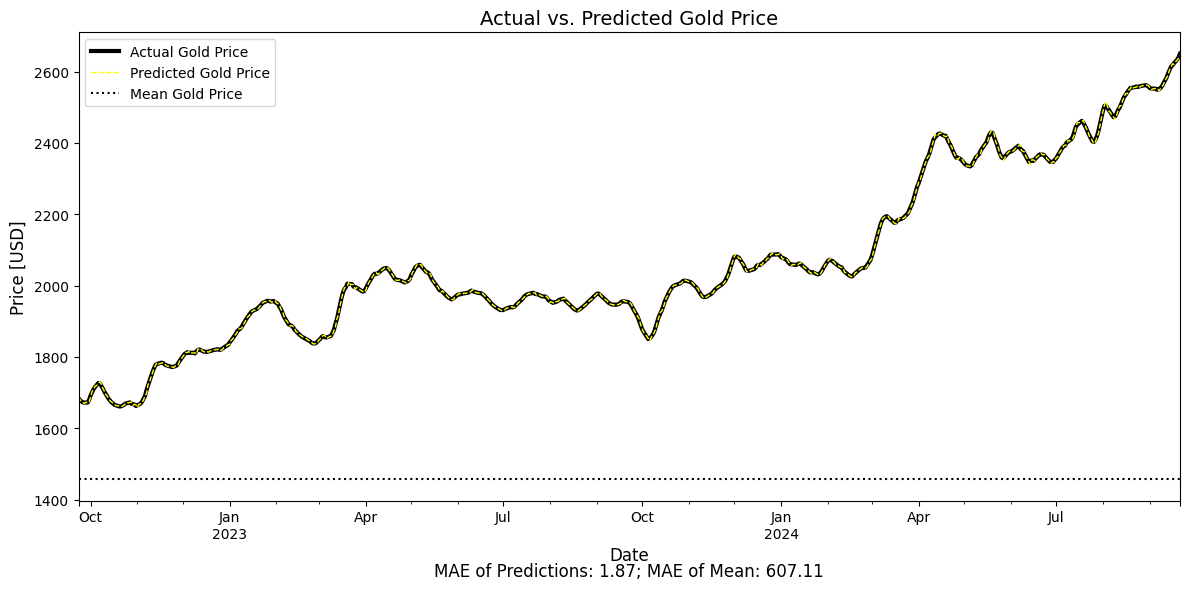

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Actual Gold Price with thicker black line
df_results['Actual Gold Price'].plot(
    ax=ax,
    linewidth=3,  # Thicker line for Actual
    color='black',  # Color for Actual
    style='-',  # Solid line for Actual
)

# Plot Predicted Gold Price with thinner grey line
df_results['Predicted Gold Price'].plot(
    ax=ax,
    linewidth=1,  # Thinner line for Predicted
    color='yellow',  # Use grey for Predicted
    style='--'  # Dashed line for Predicted
)

# Plot the Mean Gold Price with a dotted line in black
df_results['Mean Gold Price'].plot(
    ax=ax,
    style=':',
    color='black',
    linewidth=1.5  # Line width for Mean
)

# Customize the axis labels and title
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price [USD]', fontsize=12)
ax.set_title('Actual vs. Predicted Gold Price', fontsize=14)

# Add a caption with MAE values
caption = f"MAE of Predictions: {mae_pred:.2f}; MAE of Mean: {mae_av:.2f}"
ax.text(0.5, -0.15, caption, ha='center', va='center', transform=ax.transAxes, fontsize=12)

# Add a legend for clarity
ax.legend(['Actual Gold Price', 'Predicted Gold Price', 'Mean Gold Price'], loc='upper left')

# Adjust layout to make room for the caption
plt.tight_layout()

# Show the plot
plt.show()